In [1]:

using Gen
using Distributions
using Random
using Plots

In [2]:

@gen function wright_fisher_model_complete(T::Int, M::Int)

    N_values = collect(50:10:200)
    N_idx ~ categorical(fill(1.0 / length(N_values), length(N_values)))
    N_eff = N_values[N_idx]

    s ~ normal(0.0, 0.05)

    p ~ beta(2.0, 2.0)

    X = @trace(binom(N_eff, p), :X0)

    observations = Int[]

    for t in 1:T
        p_curr = X / N_eff
        p_sel_num = p_curr * (1.0 + s)
        p_sel_den = p_sel_num + (1.0 - p_curr)
        p_sel = p_sel_num / p_sel_den

        X = @trace(binom(N_eff, p_sel), (:X, t))

        y = @trace(binom(M, X / N_eff), (:obs, t))
        push!(observations, y)
    end

    return observations
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##wright_fisher_model_complete#277", Bool[0, 0], false)

In [10]:
Random.seed!(3)

T = 40
M = 50

(trace, _) = generate(wright_fisher_model_complete, (T, M))

println("Observations (allele A counts in sample of size M each generation):")
println(get_retval(trace))

# Latent parameters
N_values = collect(50:10:200)
println("\nLatent parameters:")
println("N_eff = ", N_values[trace[:N_idx]])
println("s     = ", trace[:s])
println("X0    = ", trace[:X0], "  (initial allele count in population)")


Observations (allele A counts in sample of size M each generation):
[28, 17, 13, 22, 25, 25, 37, 29, 31, 36, 41, 36, 40, 45, 41, 39, 46, 40, 49, 43, 42, 43, 42, 49, 50, 50, 50, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

Latent parameters:
N_eff = 100
s     = 0.06816042299867799
X0    = 37  (initial allele count in population)


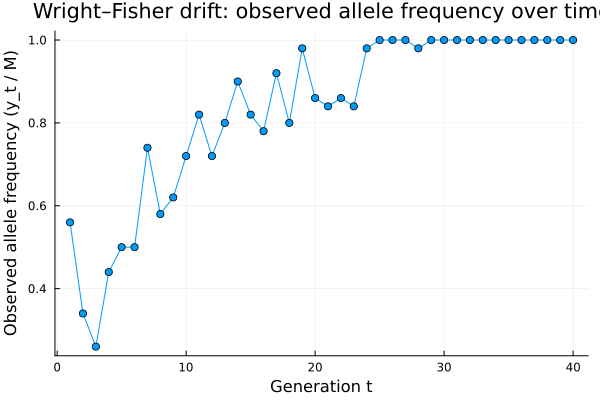

In [11]:
obs = get_retval(trace)
T = length(obs)

freq = obs ./ M

plot(
    1:T,
    freq,
    xlabel = "Generation t",
    ylabel = "Observed allele frequency (y_t / M)",
    title = "Wright–Fisher drift: observed allele frequency over time",
    legend = false,
    marker = :circle
)


In [12]:
using Gen

obs = get_retval(trace)
T = length(obs)

observations = choicemap()
for t in 1:T
    observations[(:obs, t)] = obs[t]
end


In [13]:


function logsumexp(v::AbstractVector{<:Real})
    m = maximum(v)
    return m + log(sum(exp.(v .- m)))
end

function wf_loglik_forward(N_eff::Int, s::Float64, y::Vector{Int}, M::Int;
                           a::Float64=2.0, b::Float64=2.0)
    x0_prior = Distributions.BetaBinomial(N_eff, a, b)

    logα_prev = [Distributions.logpdf(x0_prior, x) for x in 0:N_eff]

    total_logZ = 0.0
    for t in 1:length(y)
        logα_new = fill(-Inf, N_eff + 1)

        for x_new in 0:N_eff
            log_obs = Distributions.logpdf(Distributions.Binomial(M, x_new / N_eff), y[t])

            tmp = similar(logα_prev)
            for (i, x_prev) in enumerate(0:N_eff)
                p_curr = x_prev / N_eff

                p_sel_num = p_curr * (1.0 + s)
                p_sel_den = p_sel_num + (1.0 - p_curr)
                p_sel = p_sel_num / p_sel_den

                tmp[i] = logα_prev[i] + Distributions.logpdf(Distributions.Binomial(N_eff, p_sel), x_new)
            end

            logα_new[x_new + 1] = log_obs + logsumexp(tmp)
        end

        logZ_t = logsumexp(logα_new)
        logα_prev = logα_new .- logZ_t
        total_logZ += logZ_t
    end

    return total_logZ
end


wf_loglik_forward (generic function with 1 method)

In [14]:
N_values = collect(50:10:200)

s_grid = collect(range(-0.15, 0.15; length=121))  # you can tighten later
ll = Array{Float64}(undef, length(N_values), length(s_grid))

for (i, N_eff) in enumerate(N_values)
    for (j, s) in enumerate(s_grid)
        ll[i, j] = wf_loglik_forward(N_eff, s, obs, M)
    end
    println("done N_eff=", N_eff)
end

best = findmax(ll)
best_i, best_j = Tuple(best[2])
println("MAP N_eff = ", N_values[best_i], ", MAP s = ", s_grid[best_j], ", loglik=", best[1])


done N_eff=50
done N_eff=60
done N_eff=70
done N_eff=80
done N_eff=90
done N_eff=100
done N_eff=110
done N_eff=120
done N_eff=130
done N_eff=140
done N_eff=150
done N_eff=160
done N_eff=170
done N_eff=180
done N_eff=190
done N_eff=200
MAP N_eff = 110, MAP s = 0.15, loglik=-81.51194208418924


In [15]:

log_margN = similar(N_values, Float64)

for (i, N_eff) in enumerate(N_values)
    # if you want to include the Normal(0,0.05) prior over s:
    log_terms = [ll[i,j] + Distributions.logpdf(Distributions.Normal(0.0, 0.05), s_grid[j]) for j in eachindex(s_grid)]
    log_margN[i] = logsumexp(log_terms) - log(length(s_grid))  # crude Riemann sum (grid const cancels in normalization)
end

logpostN = log_margN .- logsumexp(log_margN)
postN = exp.(logpostN)

bar(N_values, postN, xlabel="N_eff", ylabel="Posterior P(N_eff)", title="Approx posterior over N_eff")
println("Posterior mean N_eff ≈ ", sum(N_values .* postN))
println("Posterior MAP N_eff = ", N_values[argmax(postN)])


Posterior mean N_eff ≈ 104.53020229350959
Posterior MAP N_eff = 80


In [18]:
using Gen


function wf_importance_sampling(num_particles::Int, model, args::Tuple, observations::ChoiceMap)
    traces = Vector{Any}(undef, num_particles)
    logw = Vector{Float64}(undef, num_particles)

    for i in 1:num_particles
        tr, lw = generate(model, args, observations)
        traces[i] = tr
        logw[i] = lw
    end

    m = maximum(logw)
    w = exp.(logw .- m)
    w ./= sum(w)

    return traces, w, logw
end

Nparticles = 2000

traces_is, w_is, logw_is = wf_importance_sampling(Nparticles, wright_fisher_model_complete, (T, M), observations)

println("IS: sum(w) = ", sum(w_is))
println("IS: ESS ≈ ", 1 / sum(w_is .^ 2))

# Weighted posterior summaries:
Nidx_vals = [tr[:N_idx] for tr in traces_is]
s_vals    = [tr[:s]     for tr in traces_is]

Nidx_mean = sum(w_is .* Nidx_vals)
s_mean    = sum(w_is .* s_vals)

println("IS posterior mean N_idx ≈ ", Nidx_mean)
println("IS posterior mean s ≈ ", s_mean)

# Weighted posterior over N_idx (histogram)
K = maximum(Nidx_vals)
post_Nidx_is = zeros(K)
for (k, w) in zip(Nidx_vals, w_is)
    post_Nidx_is[k] += w
end

println("IS MAP N_idx = ", argmax(post_Nidx_is), " (prob ≈ ", maximum(post_Nidx_is), ")")


IS: sum(w) = 1.0
IS: ESS ≈ 1.0003088026883413
IS posterior mean N_idx ≈ 14.999765516039648
IS posterior mean s ≈ 0.046253440424062216
IS MAP N_idx = 15 (prob ≈ 0.9998456278890759)


In [30]:
using Gen

mh_steps = 20_000
window   = 5

tr, _ = generate(wright_fisher_model_complete, (T, M), observations)

Nidx_samples = Int[]
accepted = 0

for it in 1:mh_steps
    t0 = rand(0:(T - window))
    x_addrs = [(:X, t) for t in t0:(t0 + window)]
    sel = select(:N_idx, x_addrs...)
    local tr_new, did_accept
    try
        tr_new, did_accept = mh(tr, sel)
    catch e
        if e isa DomainError
            did_accept = false
            tr_new = tr
        else
            rethrow(e)
        end
    end

    if did_accept
        tr = tr_new
        accepted += 1
    end
    push!(Nidx_samples, tr[:N_idx])
end

accept_rate = accepted / mh_steps
println("MH (local window) acceptance rate ≈ ", accept_rate)
K = maximum(Nidx_samples)
post_Nidx_mh = zeros(K)
for k in Nidx_samples
    post_Nidx_mh[k] += 1
end
post_Nidx_mh ./= sum(post_Nidx_mh)

if @isdefined N_values
    map_idx = argmax(post_Nidx_mh)
    map_N_eff = N_values[map_idx]
    mean_N_eff = sum(N_values[1:K] .* post_Nidx_mh)
    println("MH MAP N_idx = ", map_idx, " (prob ≈ ", maximum(post_Nidx_mh), ")")
    println("MH MAP N_eff = ", map_N_eff)
    println("MH posterior mean N_eff ≈ ", mean_N_eff)
else
    println("MH MAP N_idx = ", argmax(post_Nidx_mh), " (prob ≈ ", maximum(post_Nidx_mh), ")")
    println("MH posterior mean N_idx ≈ ", sum((1:K) .* post_Nidx_mh))
end


MH (local window) acceptance rate ≈ 0.01355
MH MAP N_idx = 1 (prob ≈ 0.99935)
MH MAP N_eff = 50
MH posterior mean N_eff ≈ 50.012
